### Workflow

1. Create a class that inherits from nn.Module and implement the following methods:
   + `__init__` (put the convolutional blocks here)
   + `forward` (this will take a properly formatted T1-w image as input and, once trained, output an approximate T2-w image of the same shape as the input image)
1. Verify that the forward pass works by running an image from the training set through the network. Check that the input shape is the same as the output shape.

#### Notes

* Loss function will just compare T1 and T2 images
* You many not need a loss function here. 
* Goal is simply to send an image through a forward pass of the network. Training happens in the next module.

#### Questions

* How would you reformulate this problem as a GAN?  Why would a GAN necessarily work better with less training data?
>   Note that there are other techniques to accomplish this image transformation task (e.g., generative adversarial networks), but since we have a large set of paired data, we can use supervised techniques like we are doing here.
* Downsample and upsample or just keep things simple and the same dimension? 


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [64]:
### Model Architecture 
class MRConvNet(nn.Module):
    def __init__(self, nChans=[16,1]):
        super(MRConvNet, self).__init__()
        self.conv1 = nn.Conv3d(1, nChans[0], 3, padding=1)
        self.bnorm = nn.BatchNorm3d(nChans[0])
        self.drop1 = nn.Dropout3d(p=0.3)
        self.conv2 = nn.Conv3d(nChans[0], nChans[1], 3, padding=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bnorm(x) #some debate about whether or not to apply batchnorm before or after the nonlinearity. 
        x = self.drop1(x)
        x = F.relu(self.conv2(x))       
        return x



In [65]:
### instantiate model and try out the forward() pass. 
mcn = MRConvNet()

In [66]:
# Load a raw image
import nibabel as nib

def load_mr_image(subj, ttype):
    suff = ttype.upper()
    if ttype == 't2': 
        suff = f'{suff}_reg'
    return nib.load(f'./data/small/{ttype}/{subj}-{suff}_fcm.nii.gz')

SUBJ = 'IXI102-HH-1416'

image = load_mr_image(SUBJ, 't1')
image_data = image.get_fdata()

print(type(image_data))
print(image_data.shape)


<class 'numpy.ndarray'>
(120, 120, 90)


In [67]:
# Convert ND array to tensor and reshape it
# - https://pytorch.org/docs/master/generated/torch.nn.Conv3d.html  (B x C x D x H x W)


# nibabel image: H x W x D (depth).  Single channel. 
# torch image: D X H X W
image_data = image_data.transpose((2, 0, 1)) #warning: not idempotent.
print(image_data.shape)


(90, 120, 120)


In [68]:
tensor = torch.from_numpy(image_data)
tensor = tensor.unsqueeze(0) # add channels
tensor = tensor.unsqueeze(0) # add batch (?)
tensor.shape

torch.Size([1, 1, 90, 120, 120])

In [69]:
# Consider trying to load part of an image from the dataset here. 

In [70]:
#out = mcn.forward(tensor.float()) #this probably works as well. 
out = mcn(tensor.float())

In [71]:
out.shape

torch.Size([1, 1, 90, 120, 120])

In [72]:
### Left off here
# x - get back to 1 channel (not 16). Need to update model arch to do this. 
# x - zero pad the image (argument to Conv3d) so that you don't accidentally trim it with the kernel.
# - build a better architecture.
# - turn the tensor back to an image so that you can visualize it (will look random.)

In [73]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
import matplotlib.pyplot as plt
import math
%matplotlib inline 

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def imshow(img, depth):
    #img = F.sigmoid(img) #do you care to rescale img values here?  Batchnorm should mess them up a lot. 
    npimg = img.squeeze().detach().numpy()[depth, :, :]
    #npimg = sigmoid(npimg) * 255
    plt.imshow(npimg)
    plt.show()

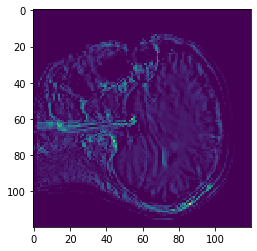

In [74]:
#I wonder why this doens't look more random...
imshow(out, 32)